# Логистическая регрессия

**Цель: Создать модель классификации для предcказания того, есть ли у пациента признаки болезни сердца, в зависимости от физических характеристик этого человека (возраст, пол, холистерол и т.д.)**



## Imports

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB # Байес
from sklearn.tree import DecisionTreeClassifier, plot_tree # Дерево решений
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier # Лог. регрессия
from sklearn.neighbors import KNeighborsClassifier # К-ближайших соседей
from sklearn.svm import SVC # Опорные вектора

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

from warnings import filterwarnings
filterwarnings('ignore')

sns.set_style('darkgrid')

## Данные

В базе данных содержатся 14 атрибутов о физическом тестировании пациентов. Они сдают кровь и выполняют небольшой физический тест. Колонка "goal" указывает на наличие заболевания сердца у пациента - 0 означает заболевания нет, 1 означает заболевание есть. В общем случае, подтвердить на 100% заболевание сердца это очень инвазивный процесс, поэтому если мы сможем построить модель, которая достаточно точно оценивает вероятность заболевания, то это поможет избежать дорогих инвазивных процедур.

Содержимое

Информация об атрибутах:

* age - возраст
* sex - пол
* cp - chest pain - тип боли в груди (4 значения)
* trestbps - resting blood pressure - давление в состоянии покоя
* chol - уровень холистерина в крови, в mg/dl
* fbs - fasting blood sugar - уровень сахара в крови, > 120 mg/dl
* restecg - resting electrocardiographic results - результаты электрокардиограммы (значения 0,1,2)
* thalach - максимальный пульс
* exang - exercise induced angina - возникновение ангины в результате упражнений
* oldpeak - пиковые значения в электрокардиограмме, как результат упражнений (по сравнению с состоянием покоя)
* slope - наклон пикового значения в электрокардиограмме, как результат упражнений (по сравнению с состоянием покоя)
* ca - количество крупных сосудов (0-3), окрашенных флурозопией
* thal -  0 = нормально; 1 = фиксированный дефект; 2 = обратимый дефект
* target - 0 означает отсутствие заболевания сердца, 1 означает наличие заболевания сердца

Источник: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df['target'].unique()

array([1, 0], dtype=int64)

### Анализ данных и визуализация данных

In [5]:
# Пропущенные значения
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
# Статистические показатели
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [8]:
# Дубликаты в данных
df[df.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [9]:
df[df['age'] == 38]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
259,38,1,3,120,231,0,1,182,1,3.8,1,0,3,0


In [3]:
# Удаляем дубликаты
df.drop(index = 163, inplace=True)

### Выбросы

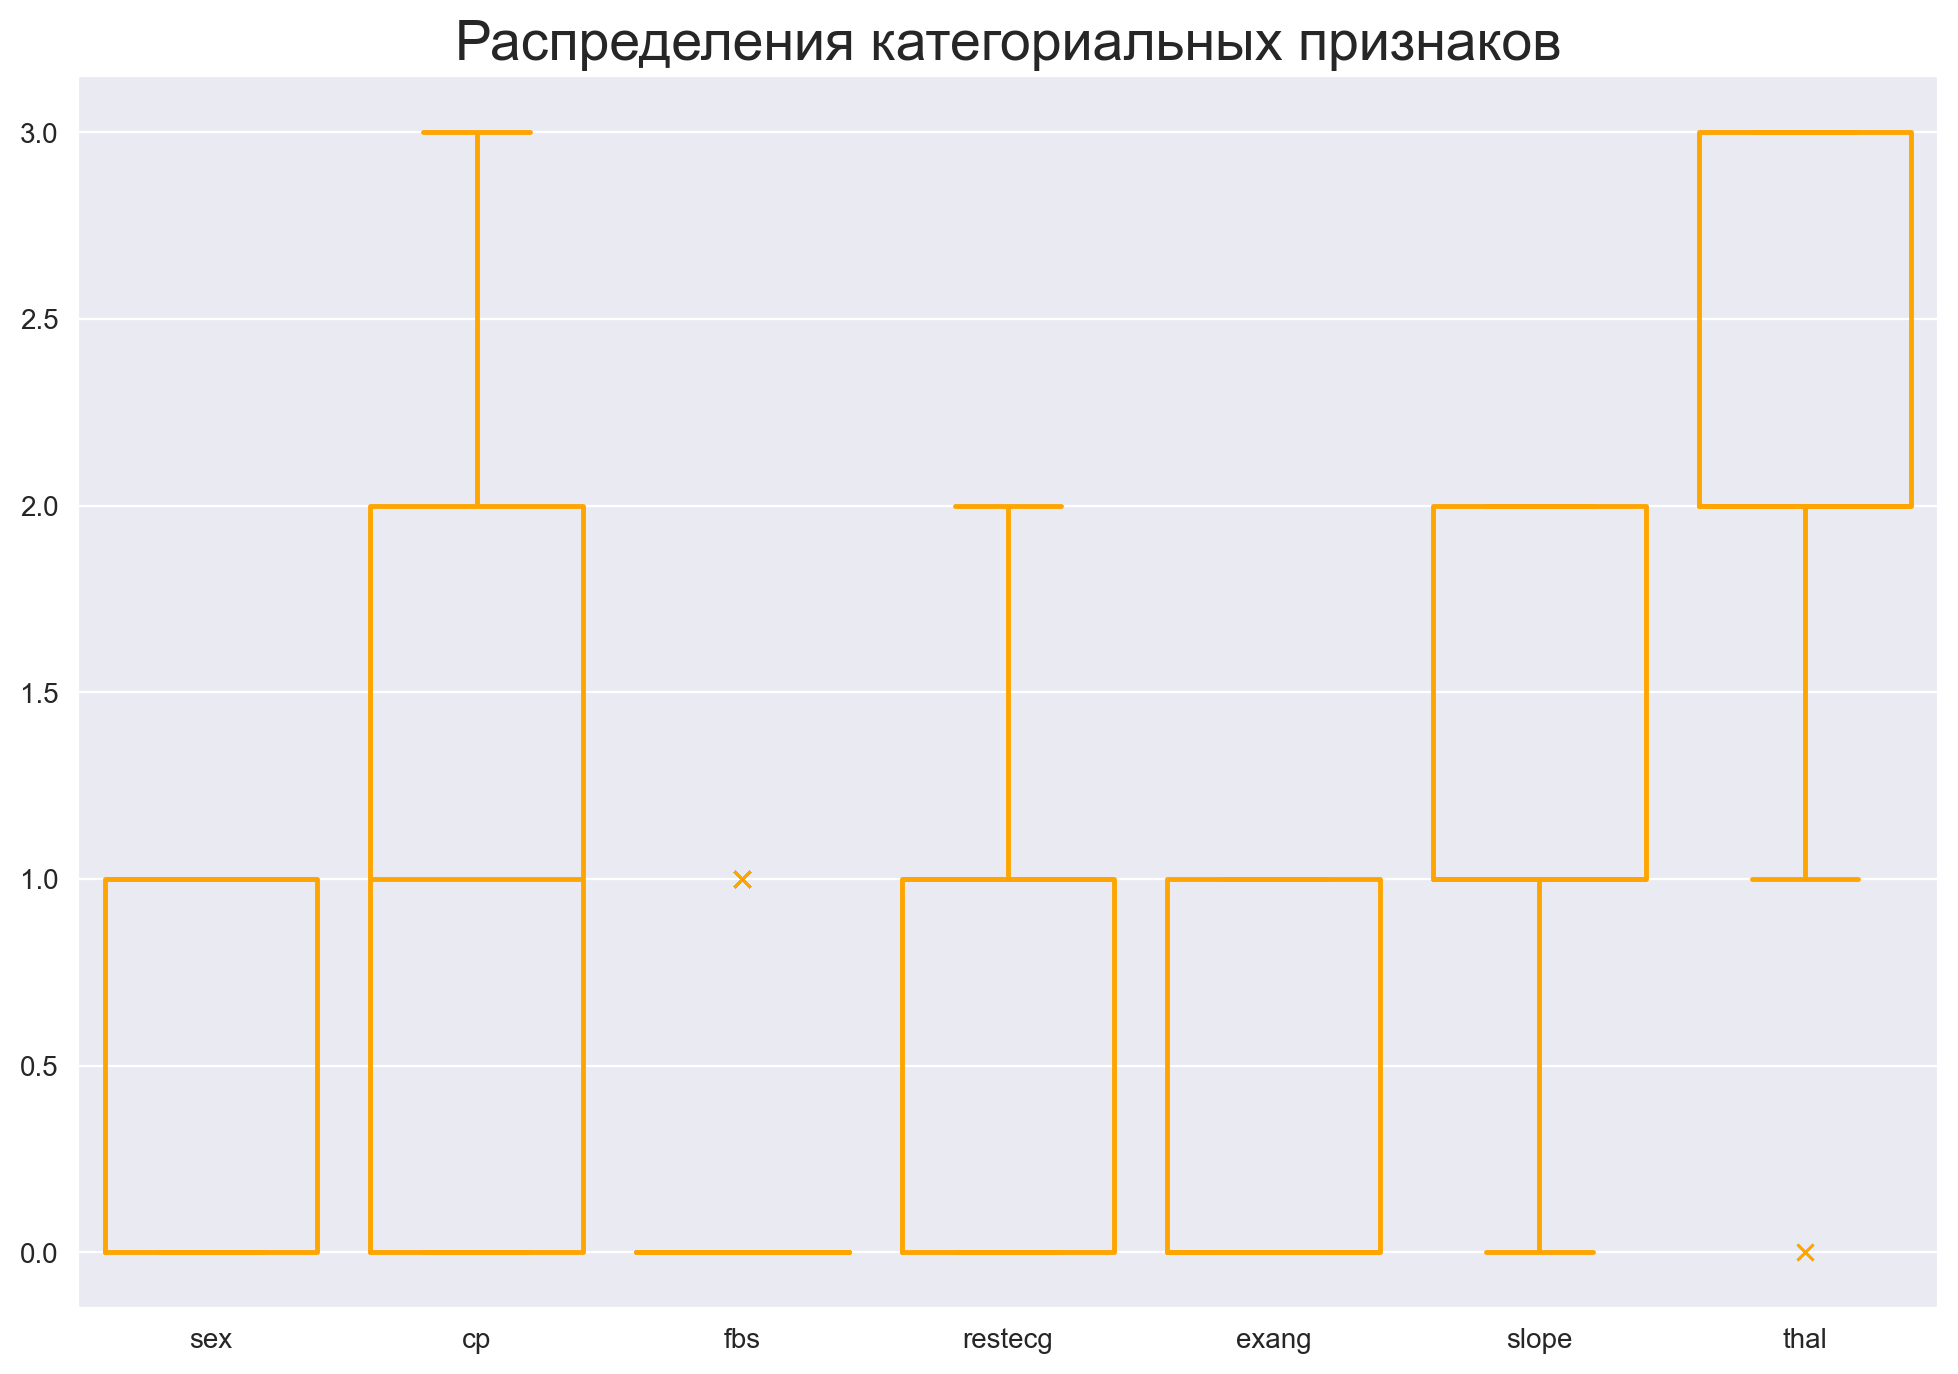

In [11]:
plt.figure(figsize=(12,8),dpi=200)
sns.boxplot(data=df.drop(['trestbps', 'chol', 'thalach', 'age', 'target', 'oldpeak', 'ca'], axis=1), fill=False, color='orange', linewidth=1.75,
           flierprops={"marker": "x"})
plt.title('Распределения категориальных признаков', fontsize=20);

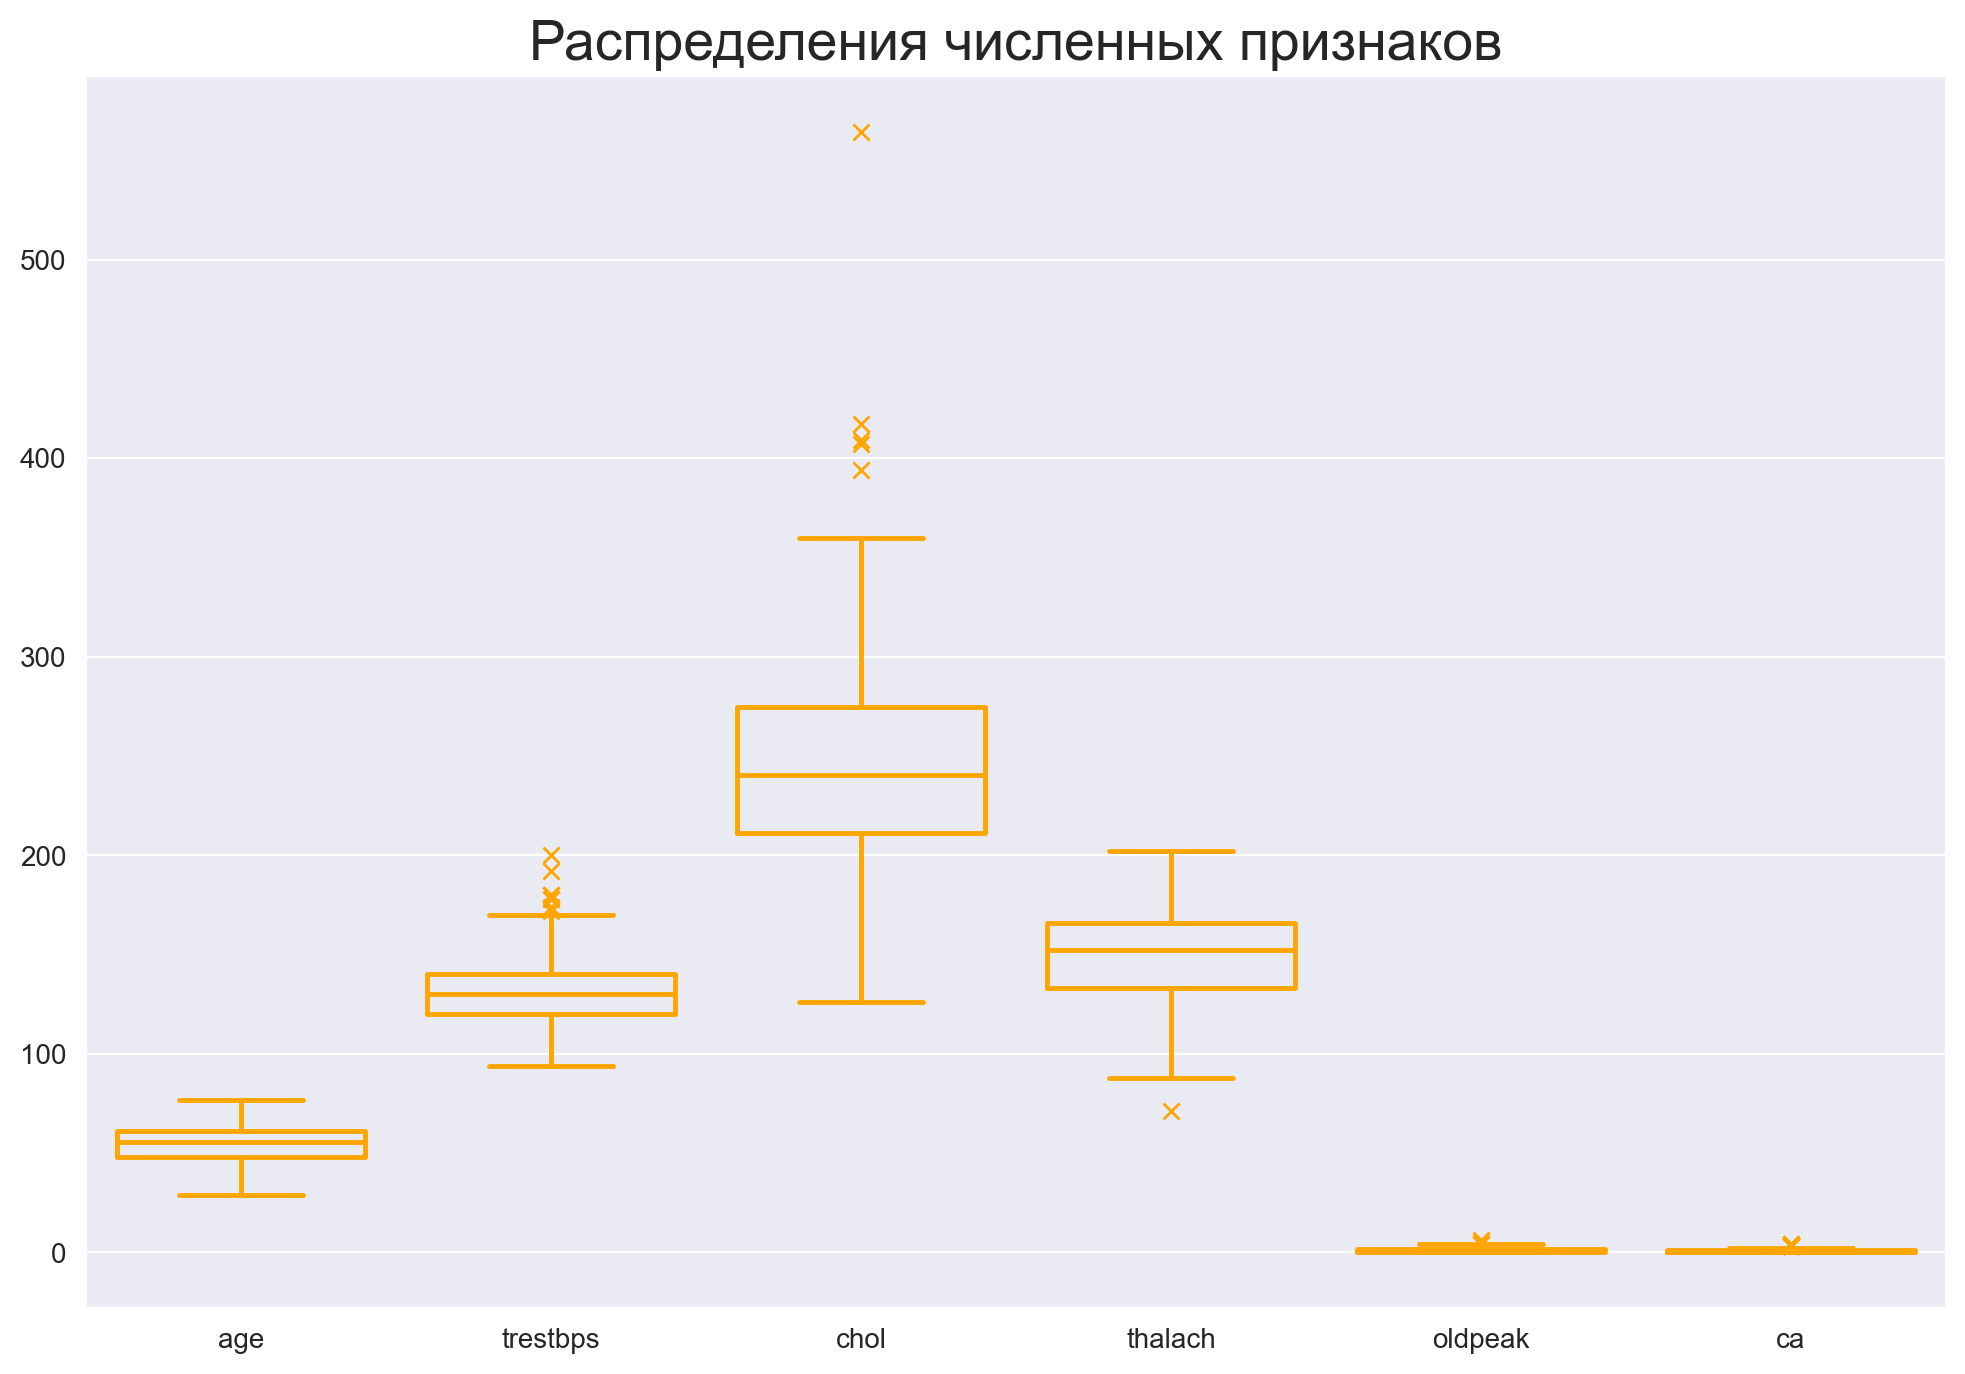

In [12]:
plt.figure(figsize=(12,8),dpi=200)
sns.boxplot(data=df.drop(['sex', 'cp', 'fbs', 'restecg', 'target', 'exang', 'slope', 'thal'], axis=1), fill=False, color='orange', linewidth=1.75,
           flierprops={"marker": "x"})
plt.title('Распределения численных признаков', fontsize=20);

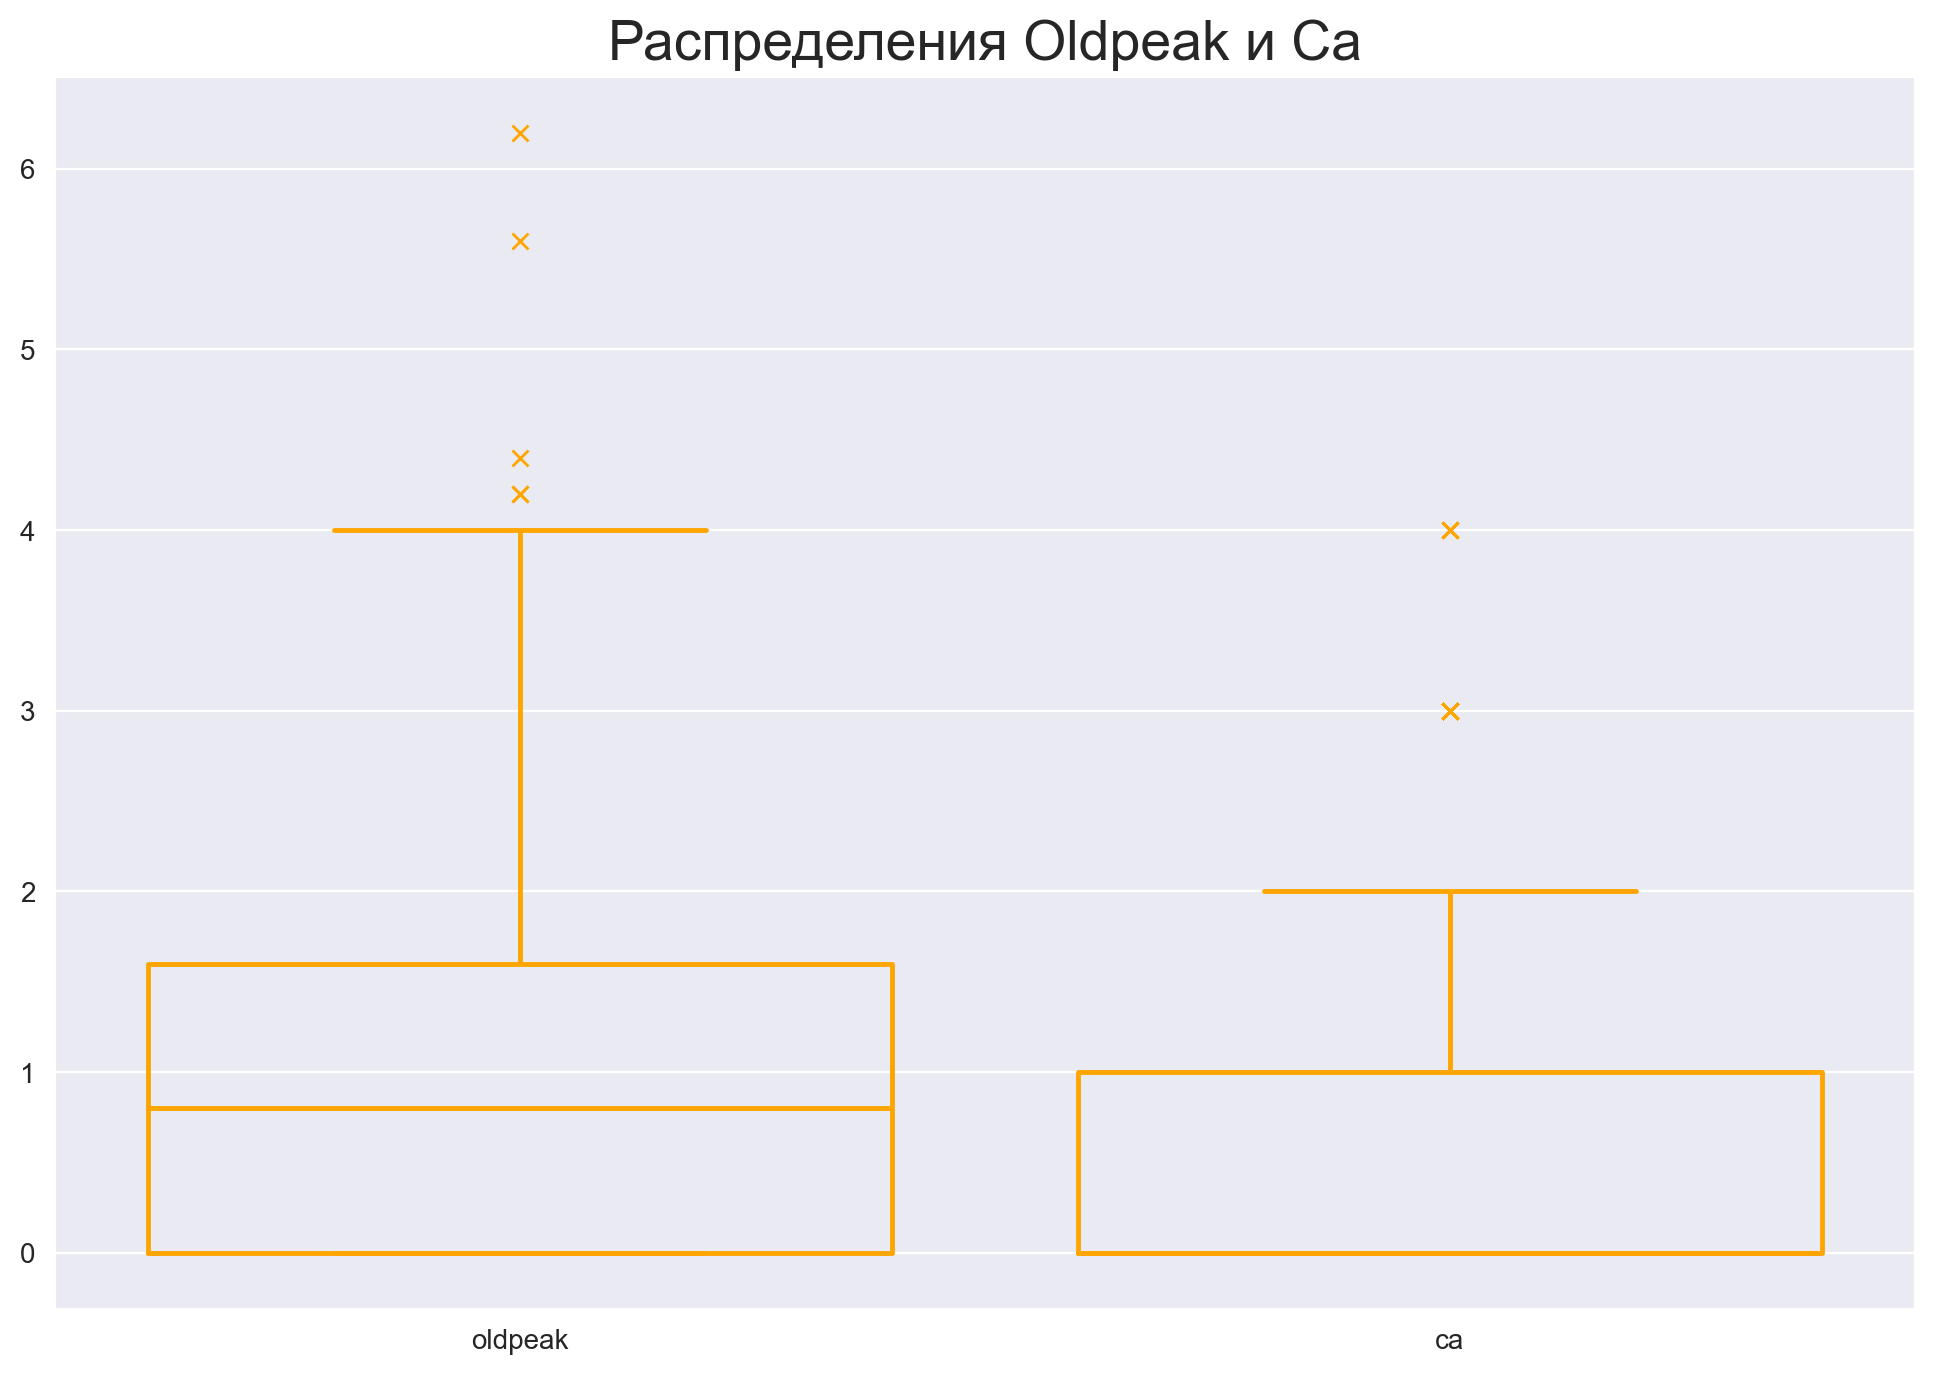

In [13]:
plt.figure(figsize=(12,8),dpi=200)
sns.boxplot(data=df.drop(['sex', 'cp', 'fbs', 'restecg', 'target', 'exang', 'slope', 'thal', 'age', 'trestbps', 'chol', 'thalach'], axis=1), fill=False, color='orange', linewidth=1.75,
           flierprops={"marker": "x"})
plt.title('Распределения Oldpeak и Ca', fontsize=20);

### Обработка выбросов в численных столбцах

In [4]:
for col in ['trestbps', 'chol', 'thalach', 'age', 'oldpeak', 'ca']:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean = df[(df[col] <= upper_bound) & (df[col] >= lower_bound)][col].mean()
    df[col] = df[col].mask(df[col] > upper_bound, mean)
    df[col] = df[col].mask(df[col] < lower_bound, mean)

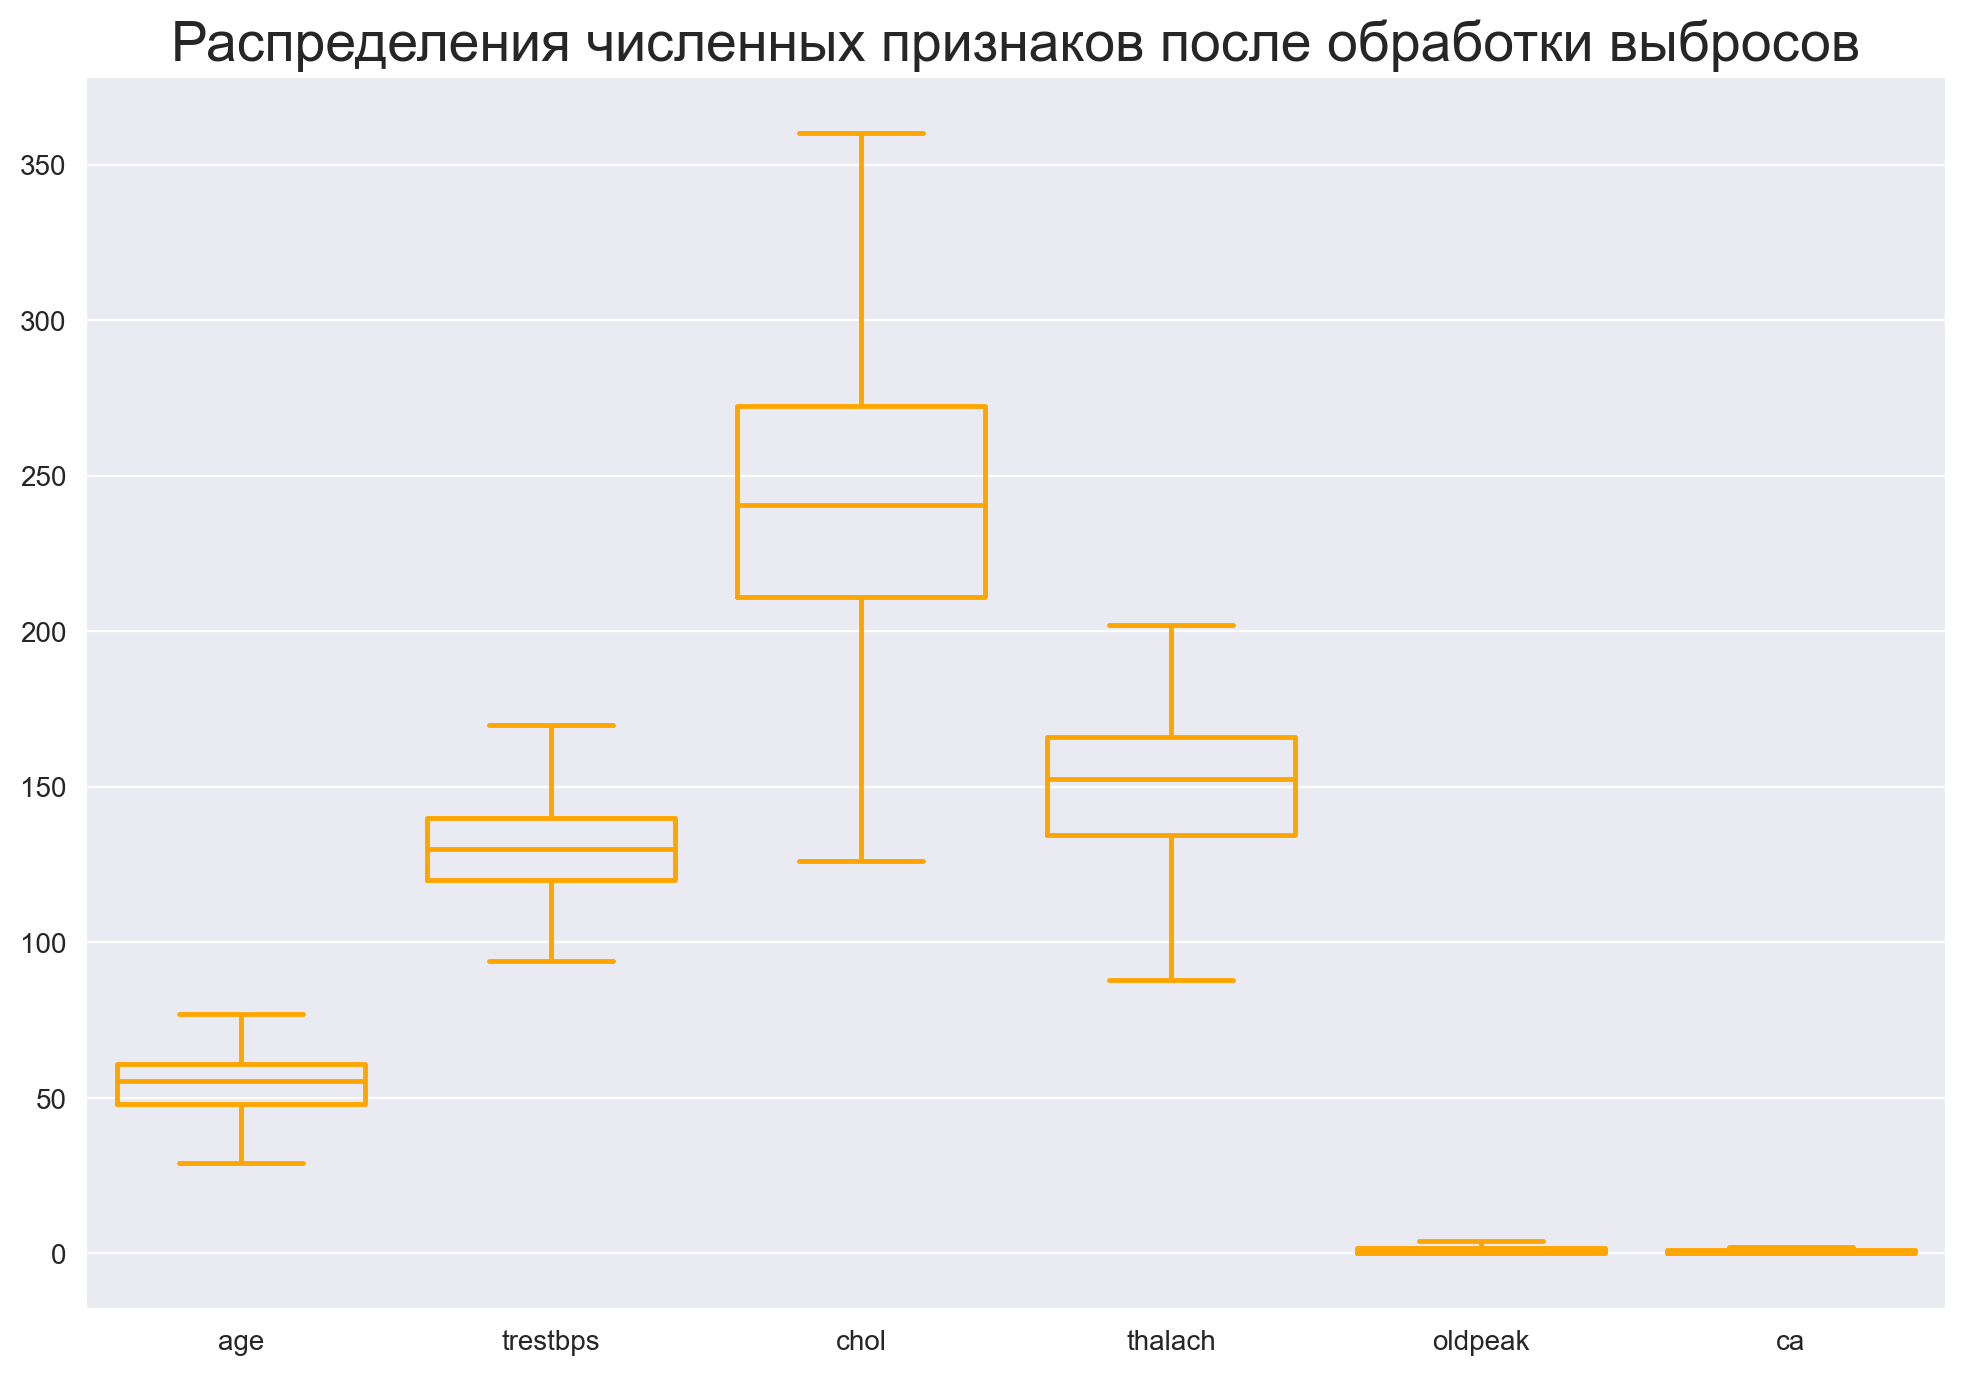

In [15]:
plt.figure(figsize=(12,8),dpi=200)
sns.boxplot(data=df.drop(['sex', 'cp', 'fbs', 'restecg', 'target', 'exang', 'slope', 'thal'], axis=1), fill=False, color='orange', linewidth=1.75,
           flierprops={"marker": "x"})
plt.title('Распределения численных признаков после обработки выбросов', fontsize=20);

### Визуализация данных

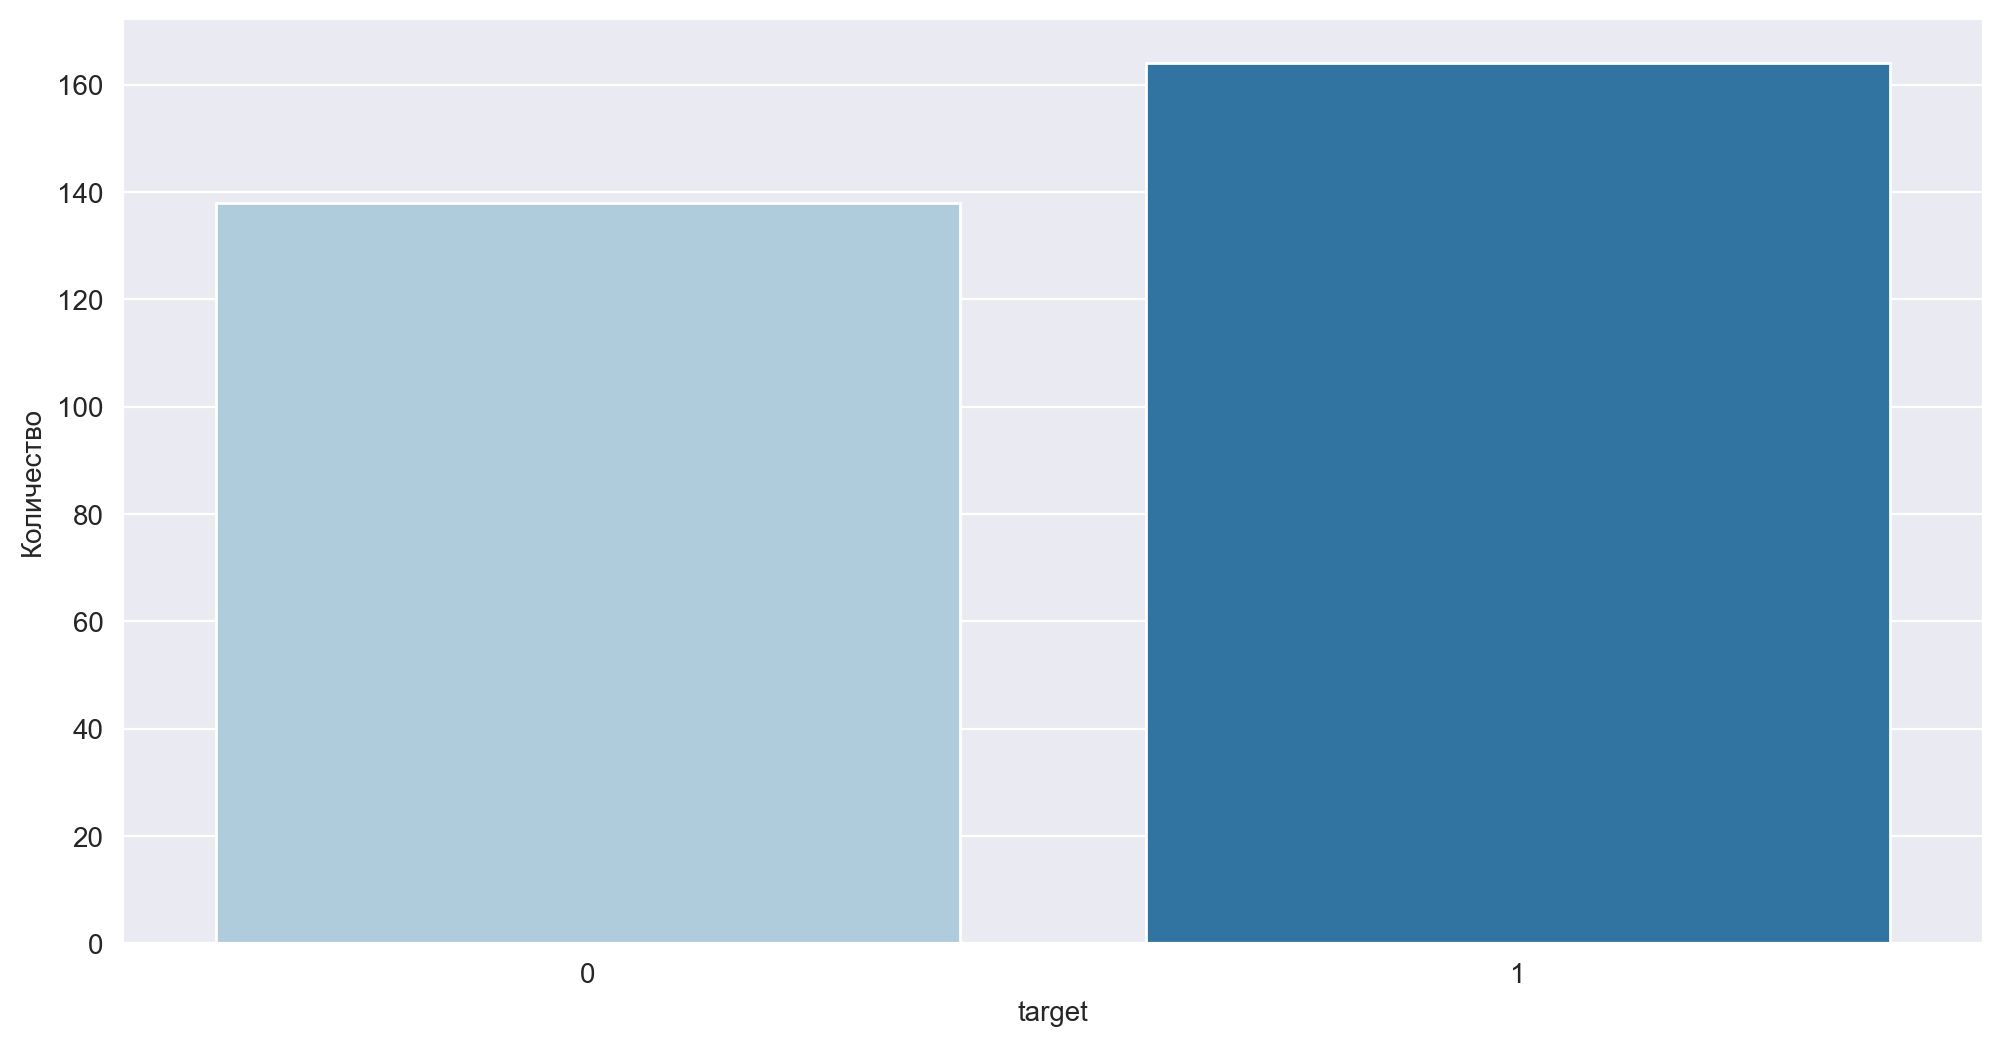

In [16]:
# Подсчёт классов
plt.figure(figsize=(12,6), dpi=200)
sns.countplot(data=df, x='target', palette='Paired');
plt.ylabel('Количество');

**График pairplot, показывающий связи между следующими колонками:**

    ['age','trestbps', 'chol','thalach','target']

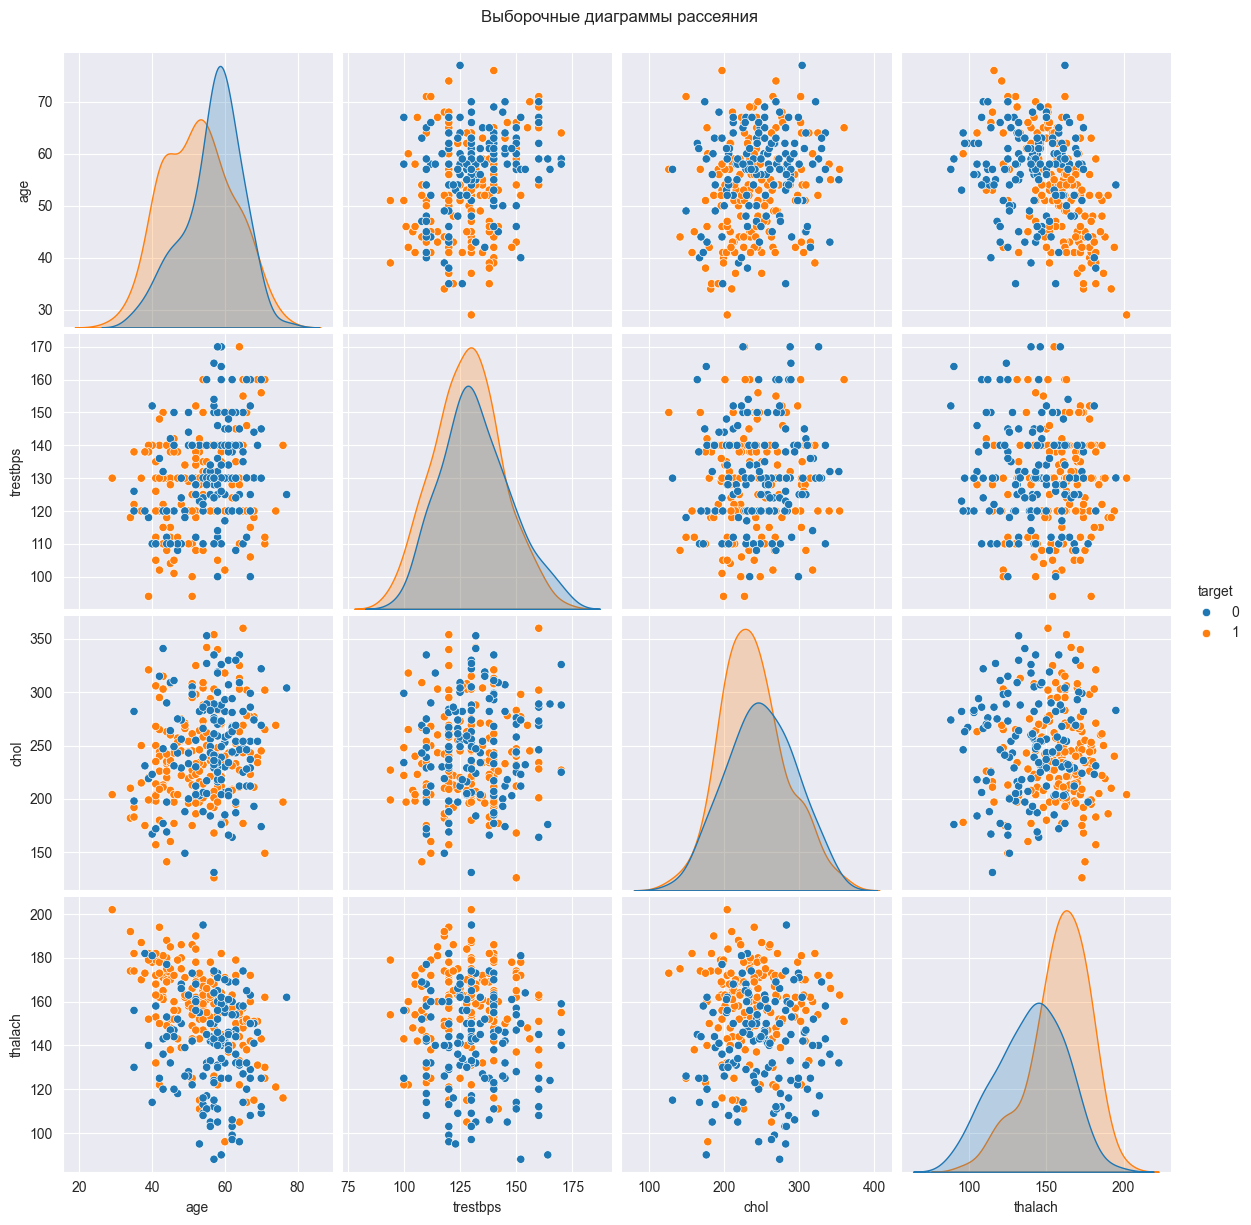

In [17]:
pair_df = df[['age','trestbps', 'chol','thalach','target']]
g = sns.pairplot(data=pair_df, hue='target', size=3);
g.fig.suptitle("Выборочные диаграммы рассеяния", y=1.02);

**Heatmap, показывающий корреляции между всеми колонками.**

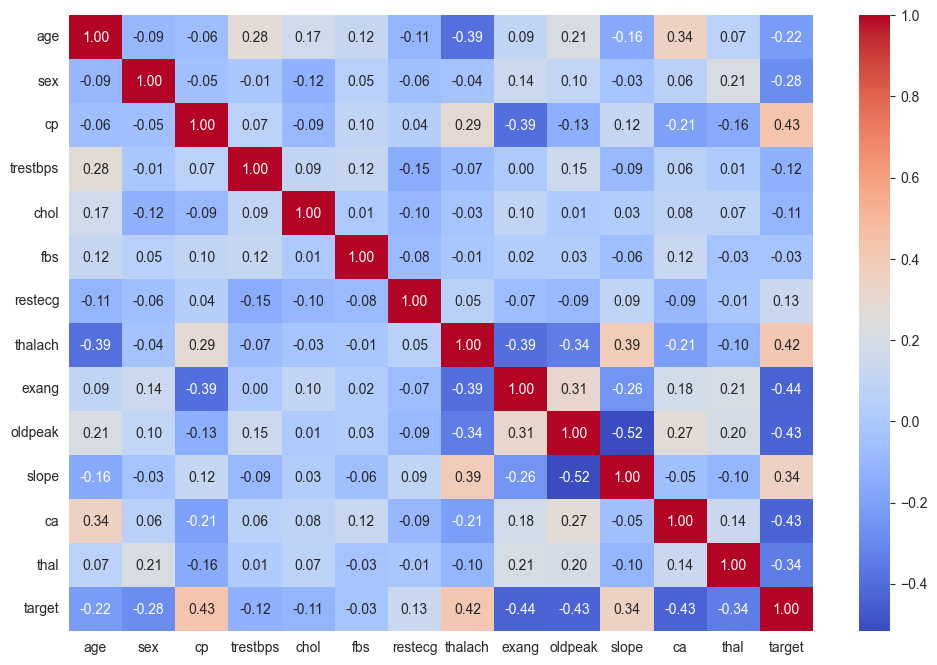

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', annot_kws={'size':10});

----
----

# Машинное обучение

## Разбиение на обучающий и тестовый наборы данных, а также масштабирование данных

In [45]:
X = df.drop('target', axis=1)
y = df['target']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [47]:
# Использование масштабирования данных
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Байес

In [48]:
bayes = GaussianNB()
bayes.fit(X_train_scale, y_train)

GaussianNB()

In [49]:
print("Априорные вероятности классов:", *bayes.class_prior_)

Априорные вероятности классов: 0.4575645756457565 0.5424354243542435


In [50]:
pd.DataFrame({'Средние значения класс 0': bayes.theta_[0],
              'Средние значения класс 1': bayes.theta_[1],
              'Дисперсия класс 0': bayes.var_[0],
              'Дисперсия класс 1': bayes.var_[1]},
              index = X.columns
            )

,Средние значения класс 0,Средние значения класс 1,Дисперсия класс 0,Дисперсия класс 1
age,0.217442,-0.183420,0.777696,1.113996
sex,0.297348,-0.250824,0.688986,1.124857
cp,-0.469844,0.396331,0.791598,0.832503
trestbps,0.101361,-0.085501,0.986388,0.995505
chol,0.098424,-0.083024,1.097381,0.902791
fbs,0.017433,-0.014705,1.032937,0.971744
restecg,-0.121760,0.102709,1.063870,0.923068
thalach,-0.412297,0.347788,0.971074,0.760052
exang,0.444417,-0.374882,1.151305,0.565228
oldpeak,0.469607,-0.396131,1.187878,0.498572


# Дерево решений

In [61]:
max_depth = np.linspace(1, 10, 10).astype('int')
min_samples_split = np.linspace(1, 10, 10).astype('int')
ccp_alpha = np.linspace(0, 1, 10)
params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha}

In [62]:
tree = DecisionTreeClassifier(criterion='gini')
grid_tree_model = GridSearchCV(tree, param_grid=params)
grid_tree_model.fit(X_train_scale, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [63]:
print(f'Найденные лучшие гиперпараметры: {grid_tree_model.best_params_}')

Найденные лучшие гиперпараметры: {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_split': 2}


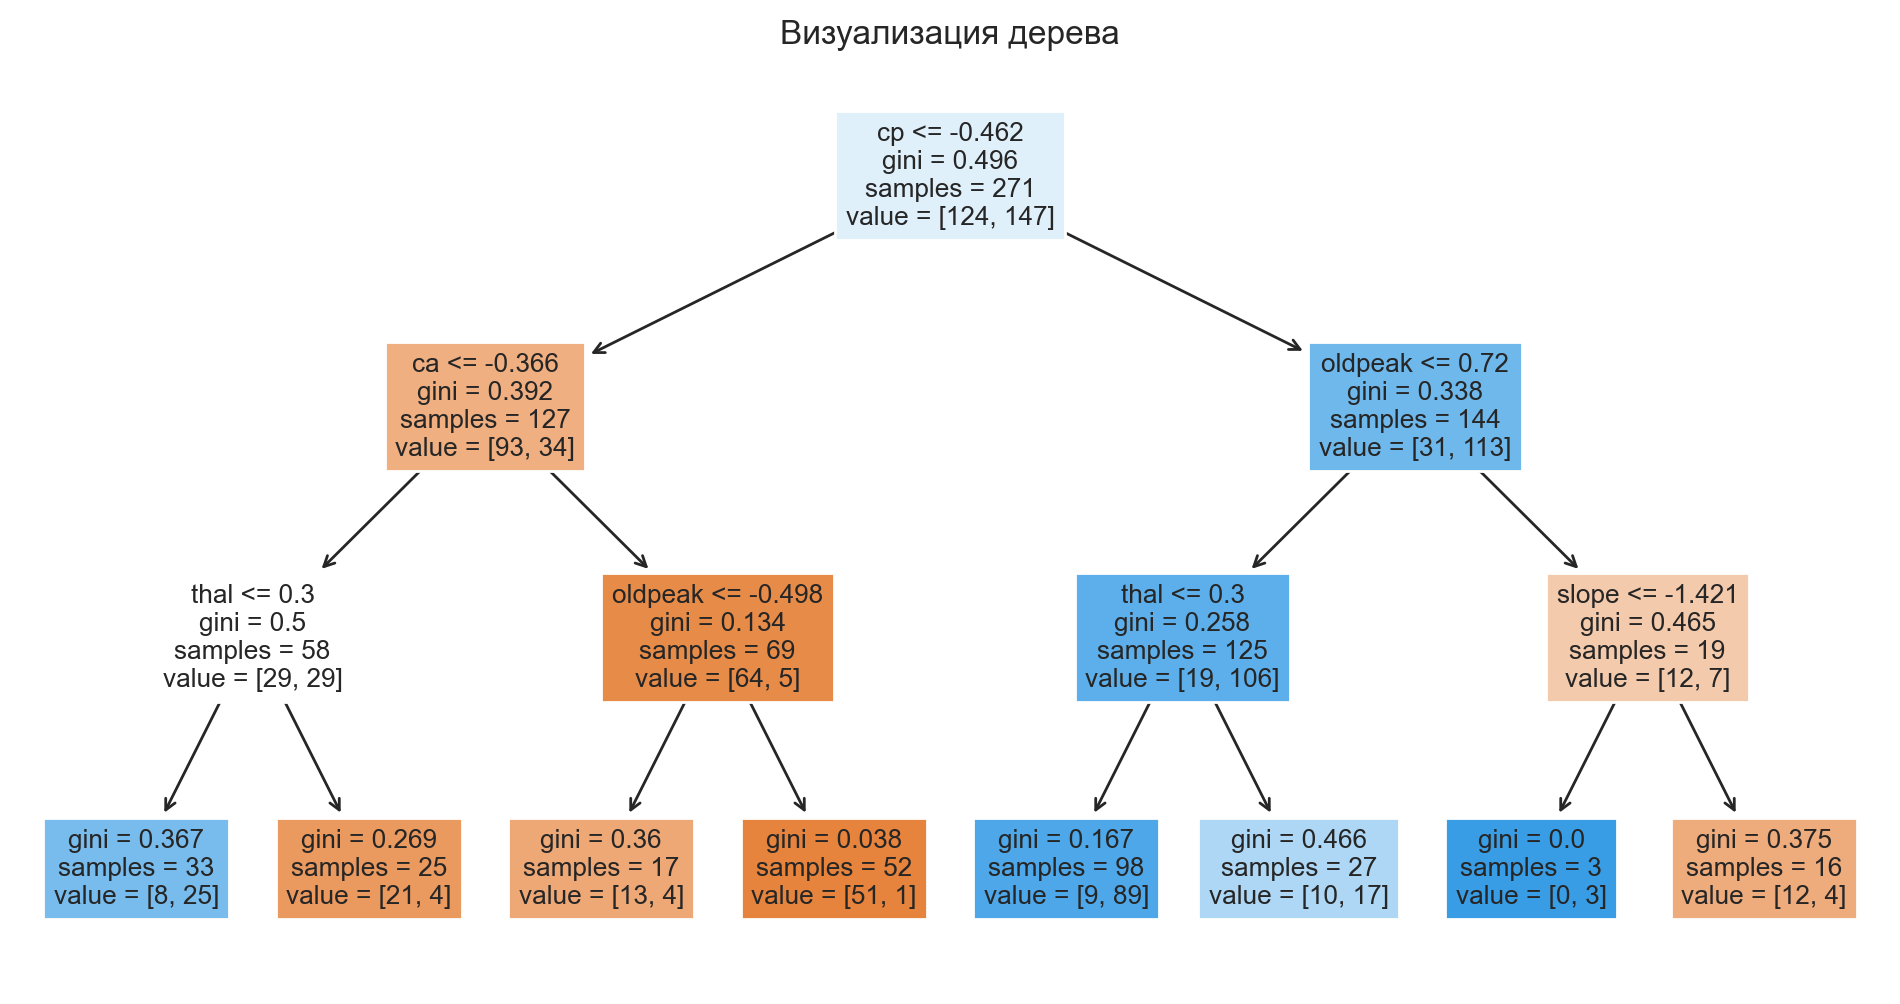

In [64]:
plt.figure(figsize=(12,6), dpi=200)
plot_tree(grid_tree_model.best_estimator_, feature_names=X_train.columns, filled=True);
plt.title('Визуализация дерева');

### LogisticRegressionCV

In [66]:
l1_ratio = np.linspace(0, 1, 30)
C = np.logspace(-4, 4, num=10)
log_cv_model = LogisticRegressionCV(cv=5, Cs=C,
                                    max_iter=10000, solver='saga', multi_class='ovr', n_jobs=-1)

In [67]:
log_cv_model.fit(X_train_scale, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                     cv=5, max_iter=10000, multi_class='ovr', n_jobs=-1,
                     solver='saga')

### Коэффициенты LogisticRegressionCV

In [75]:
print(f'Коэффициенты лог. регрессии: {log_cv_model.coef_}')
print()
print(f'Свободный коэффициент лог. регрессии: {log_cv_model.intercept_}')

Коэффициенты лог. регрессии: [[ 0.01819681 -0.7208918   0.81823579 -0.26314933 -0.23673323  0.07055751
   0.1528912   0.38414602 -0.33730928 -0.58007687  0.40571324 -0.93797299
  -0.59736732]]

Свободный коэффициент лог. регрессии: [0.11614672]


**Barplot для признаков LogisticRegressionCV**

In [78]:
# Сортируем признаки по их значениям
coefs = log_cv_model.coef_[0]
columns = X_train.columns
feature_df = pd.DataFrame({'columns': columns, 'coefs': coefs})
feature_df = feature_df.sort_values(by='coefs')
feature_df

,columns,coefs
11,ca,-0.937973
1,sex,-0.720892
12,thal,-0.597367
9,oldpeak,-0.580077
8,exang,-0.337309
3,trestbps,-0.263149
4,chol,-0.236733
0,age,0.018197
5,fbs,0.070558
6,restecg,0.152891


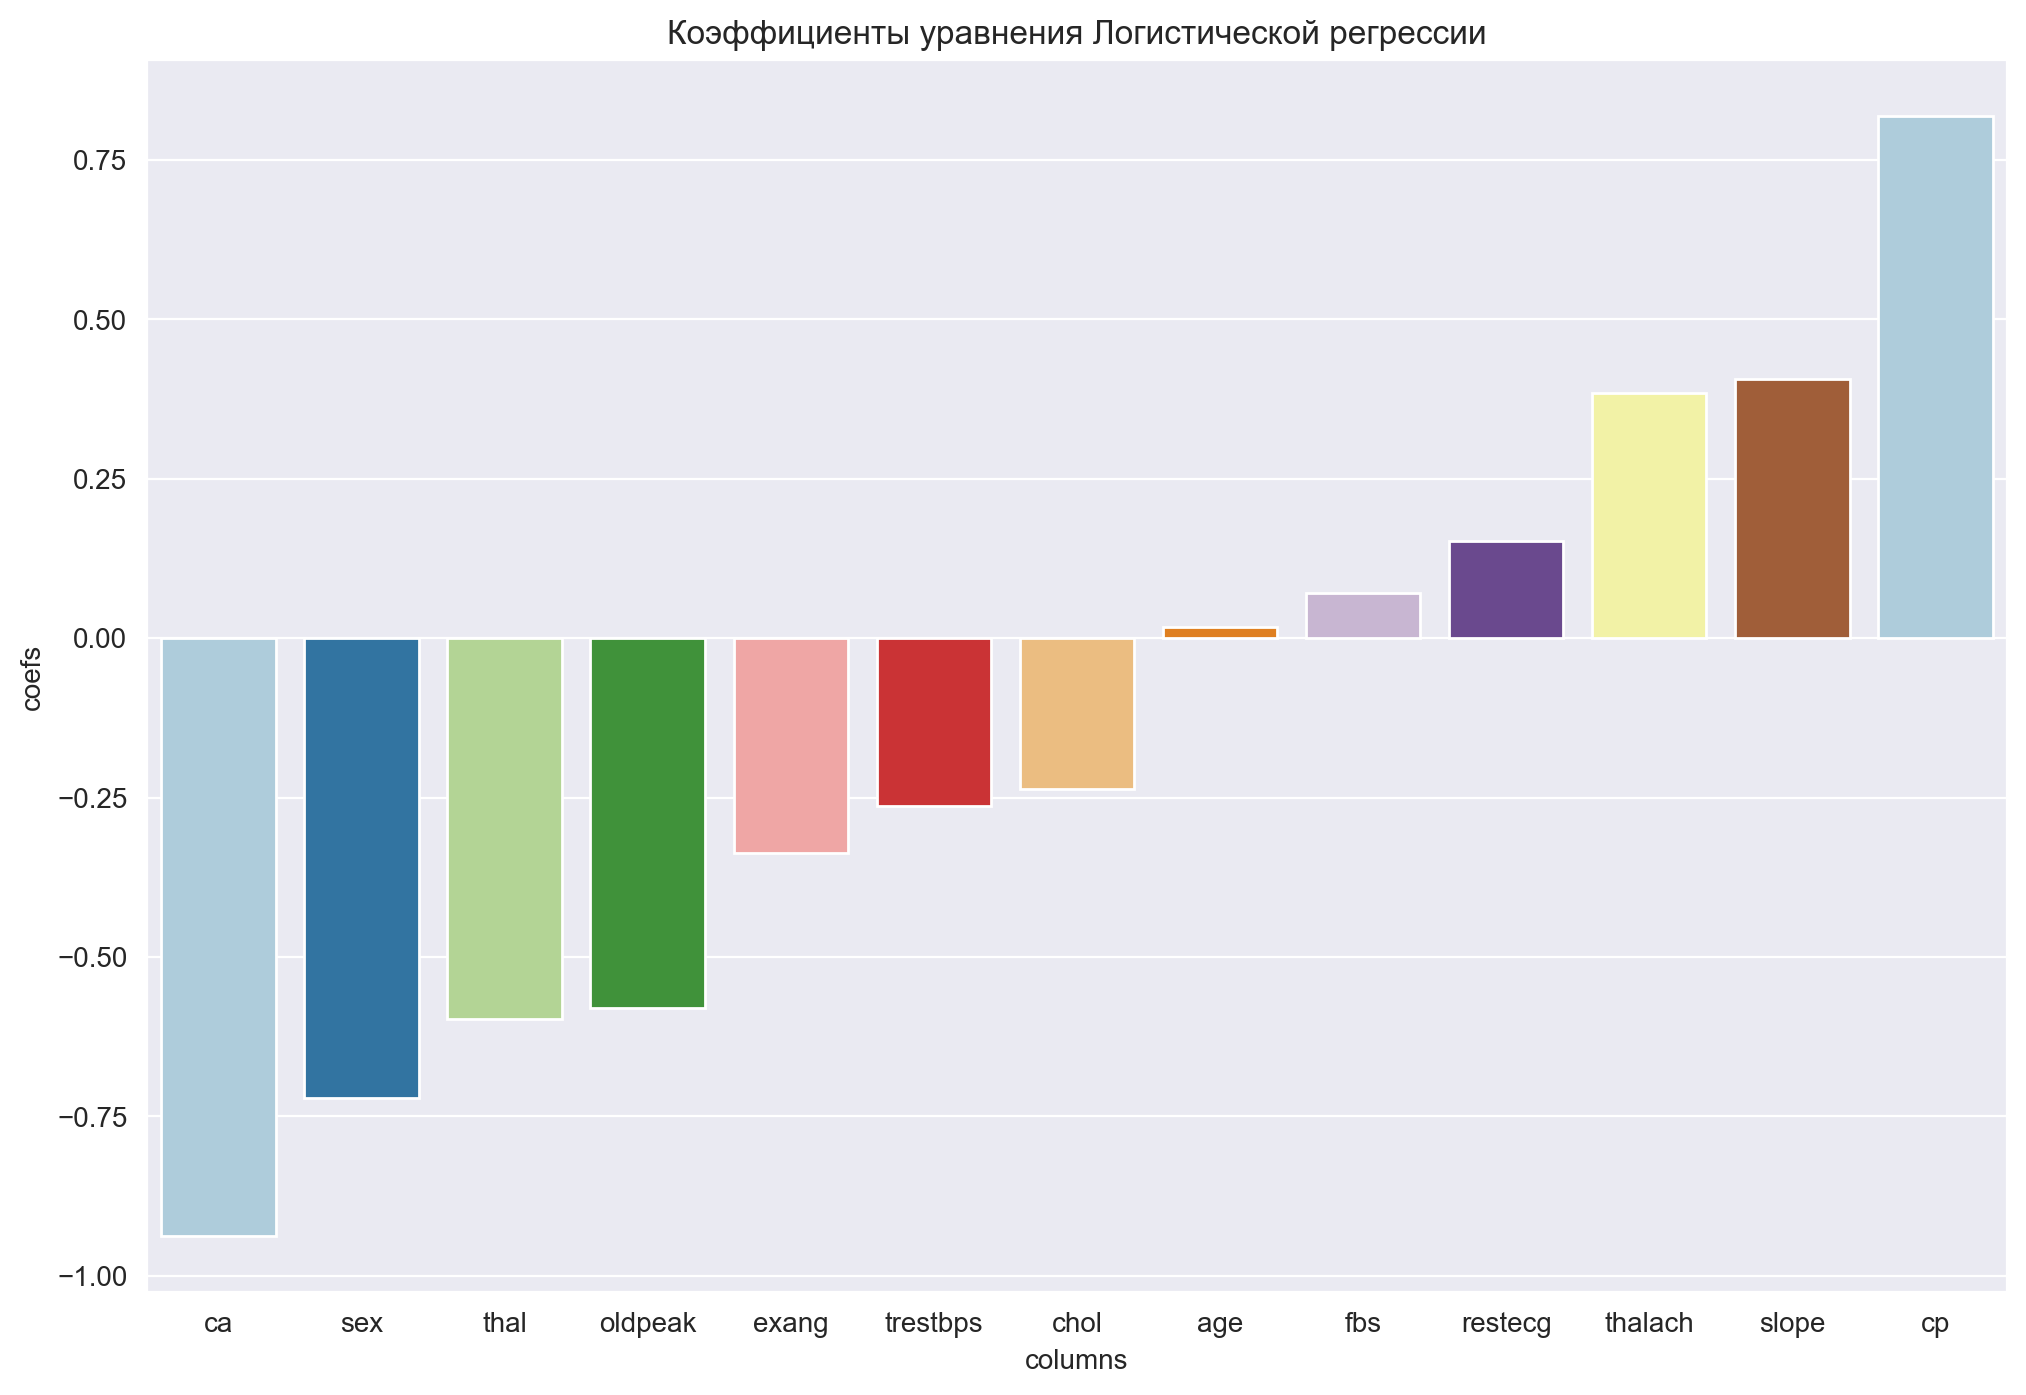

In [79]:
plt.figure(figsize=(12,8), dpi=200)
sns.barplot(x=feature_df['columns'], y=feature_df['coefs'], palette='Paired');
plt.title('Коэффициенты уравнения Логистической регрессии');

# K-ближайших соседей

In [82]:
p = [1, 2]
metrics = ['minkowsky', 'cosine']
n_neighbors = [3, 4, 5, 6, 7]
params = {'n_neighbors': n_neighbors, 'p': p, 'metric': metrics}

knn_model = KNeighborsClassifier(n_jobs=-1)
grid_knn_model = GridSearchCV(knn_model, param_grid=params)
grid_knn_model.fit(X_train_scale, y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'metric': ['minkowsky', 'cosine'],
                         'n_neighbors': [3, 4, 5, 6, 7], 'p': [1, 2]})

In [83]:
print(f'Количество соседей, которые участвуют в классификации одного образца: {grid_knn_model.estimator.n_neighbors}')
print(f'Лучшие гиперпараметры: {grid_knn_model.best_params_}')

Количество соседей, которые участвуют в классификации одного образца: 5
Лучшие гиперпараметры: {'metric': 'cosine', 'n_neighbors': 5, 'p': 1}


# SVM

In [85]:
kernel = ['linear', 'rbf']
C = np.linspace(1, 10, 20)
gamma = np.linspace(0.1, 100, 30)
params = {'kernel': kernel, 'C': C, 'gamma': gamma}

svc = SVC()
grid_svc = GridSearchCV(svc, param_grid=params)
grid_svc.fit(X_train_scale, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ]),
                         'gamma': array([  0.1       ,   3.54482759,   6.98965517,  10.43448276,
        13.87931034,  17.32413793,  20.76896552,  24.2137931 ,
        27.65862069,  31.10344828,  34.54827586,  37.99310345,
        41.43793103,  44.88275862,  48.32758621,  51.77241379,
        55.21724138,  58.66206897,  62.10689655,  65.55172414,
        68.99655172,  72.44137931,  75.8862069 ,  79.33103448,
        82.77586207,  86.22068966,  89.66551724,  93.11034483,
        96.55517241, 100.        ]),
                         'kernel': ['linear', 'rbf']})

In [86]:
print(f'Лучшие гиперпараметры: {grid_svc.best_params_}')

Лучшие гиперпараметры: {'C': 3.3684210526315788, 'gamma': 0.1, 'kernel': 'linear'}


In [87]:
coefs = grid_svc.best_estimator_.coef_[0]
columns = X_train.columns
feature_df = pd.DataFrame({'columns': columns, 'coefs': coefs})
feature_df = feature_df.sort_values(by='coefs')
print(f"Свободный член: {grid_svc.best_estimator_.intercept_[0]:.4f}")
feature_df

Свободный член: 0.1457


,columns,coefs
11,ca,-0.712134
9,oldpeak,-0.595323
1,sex,-0.591697
12,thal,-0.524090
3,trestbps,-0.226551
4,chol,-0.215344
8,exang,-0.189252
6,restecg,0.004565
0,age,0.032963
5,fbs,0.082269


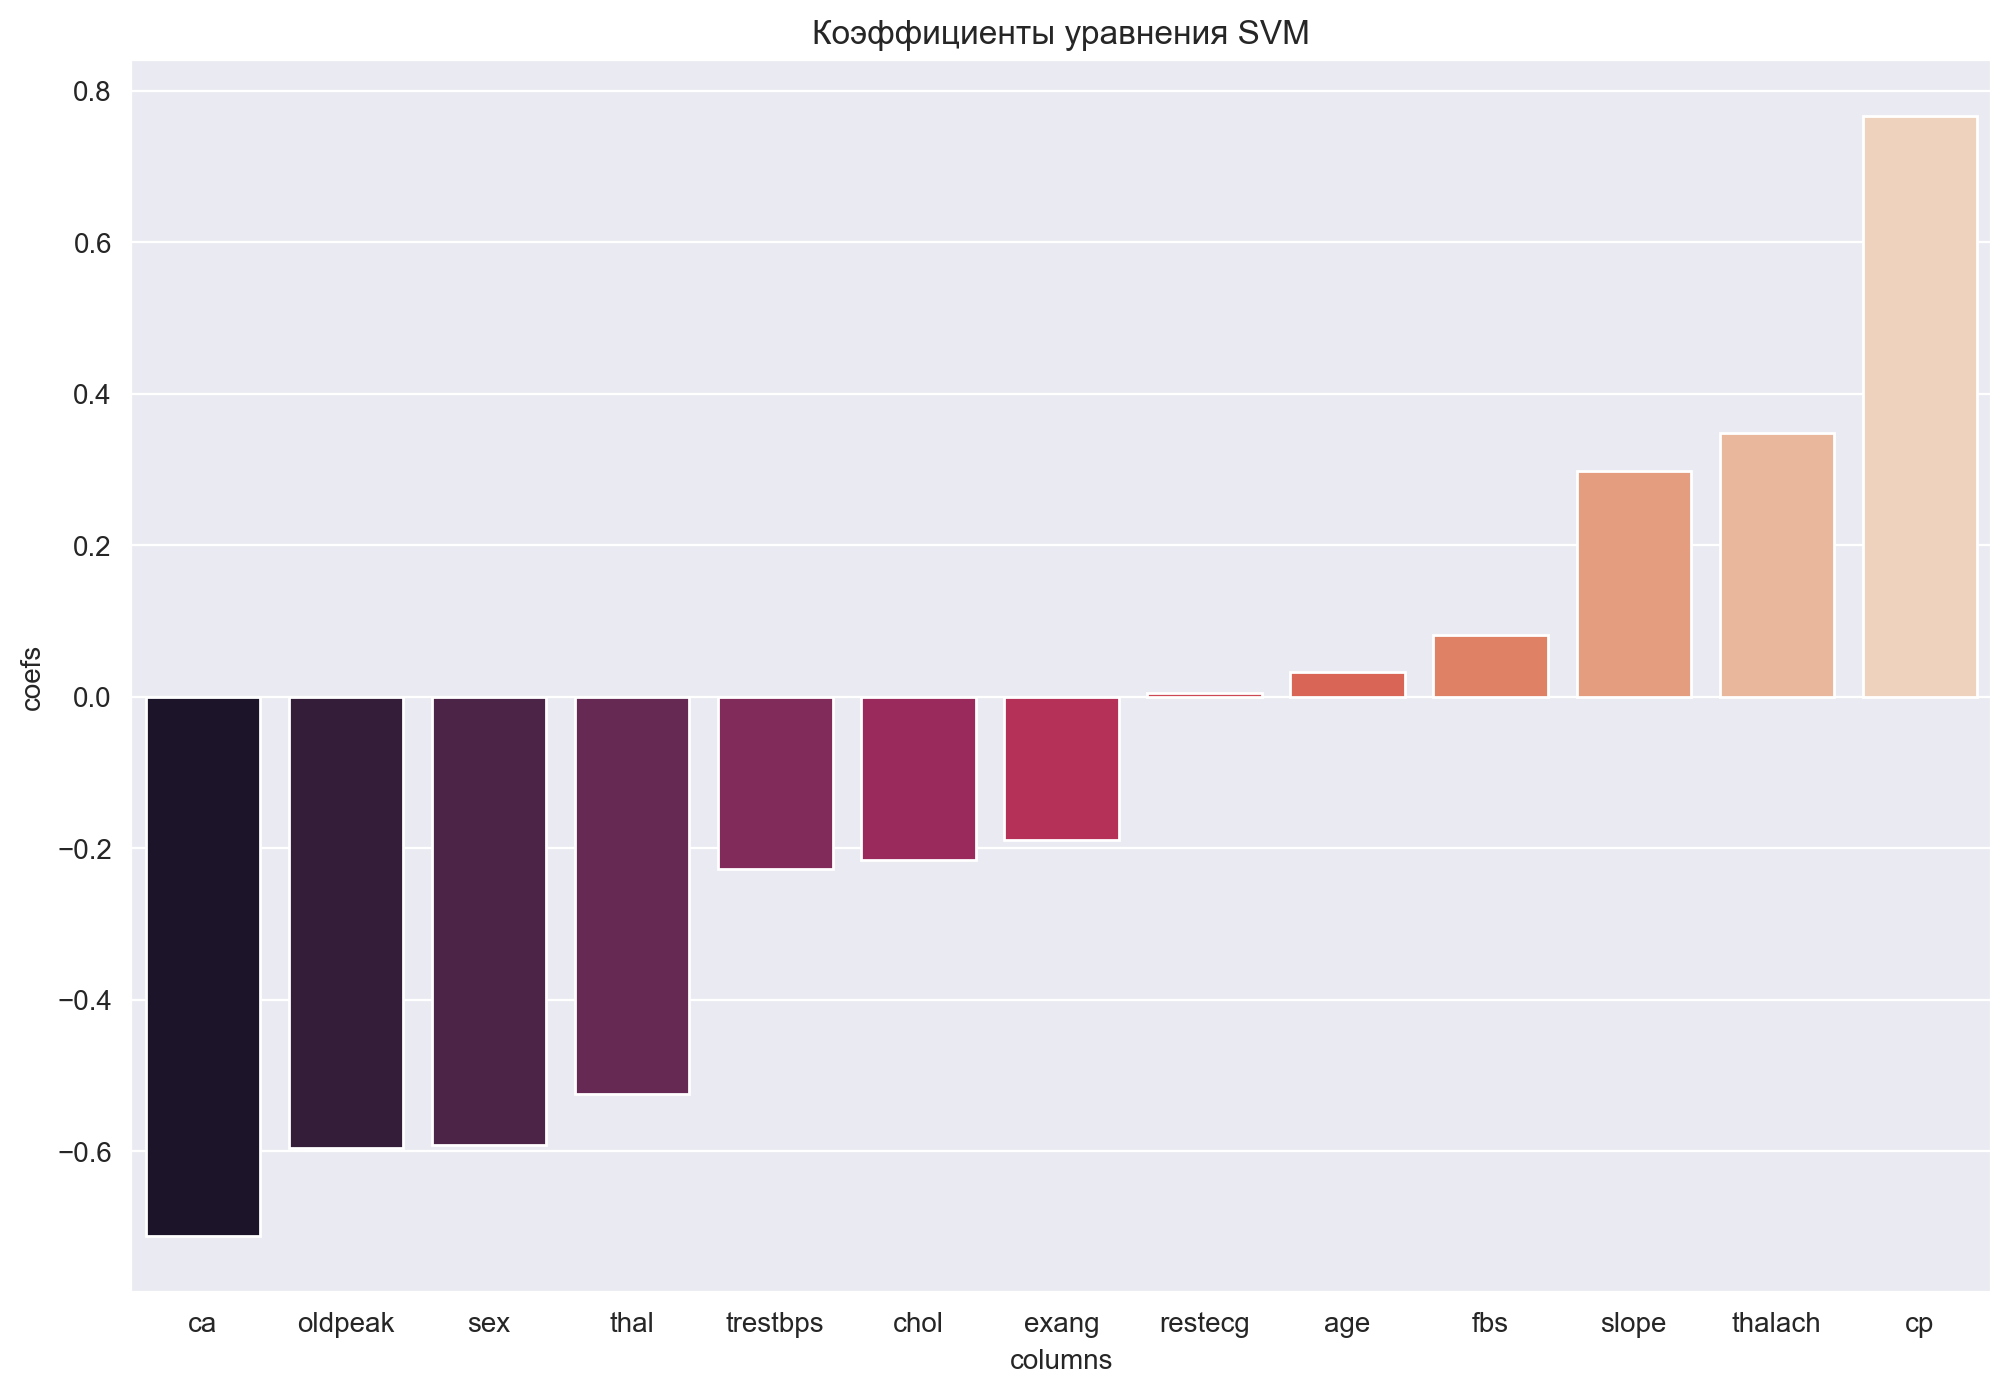

In [88]:
plt.figure(figsize=(12,8), dpi=200)
sns.barplot(x=feature_df['columns'], y=feature_df['coefs'], palette='rocket');
plt.title('Коэффициенты уравнения SVM');

---------

## Оценка моделей

In [43]:
def print_all_metrics(model, X_test, y_test, name):
    preds = model.predict(X_test)
    
    # Conf matrix
    print('Матрица ошибок:')
    print(confusion_matrix(y_test, preds))
    print()
    print()
    
    # Display conf matrix
    fig, ax = plt.subplots(figsize=(12,8))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='rocket', ax=ax)
    plt.grid(False)
    plt.title(f'Матрица ошибок для {name}')
    plt.show()
    
    # Classification report
    print('Отчёт по классификации:')
    print(classification_report(y_test, preds))
    print()

    # PR-кривая
    PrecisionRecallDisplay.from_estimator(model, X_test_scale, y_test);
    plt.title(f'PR-кривая для {name}')
    plt.show()
    
    # ROC-кривая 
    RocCurveDisplay.from_estimator(model, X_test_scale, y_test);
    plt.title(f'ROC-кривая для {name}')
    plt.show()

Матрица ошибок:
[[14  0]
 [ 1 16]]




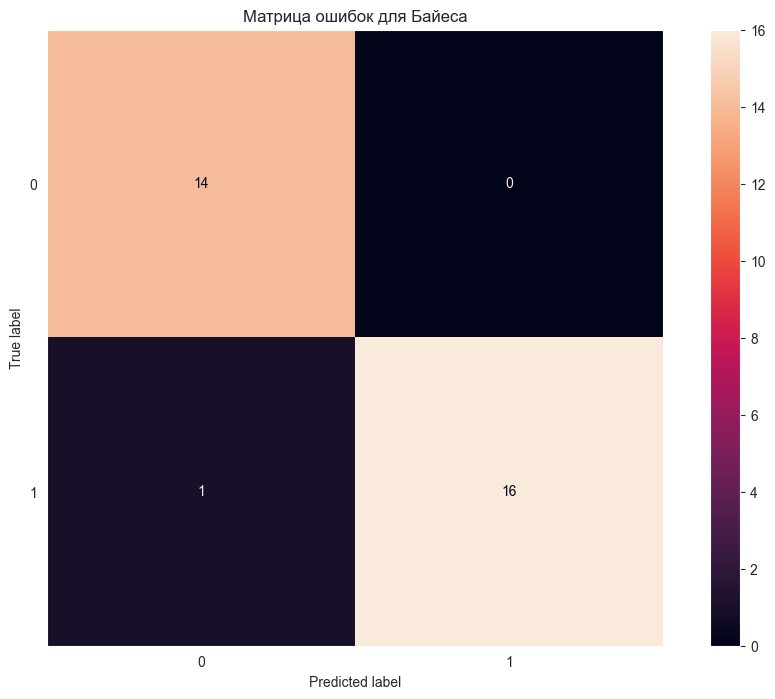

Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.94      0.97        17

    accuracy                           0.97        31
   macro avg       0.97      0.97      0.97        31
weighted avg       0.97      0.97      0.97        31




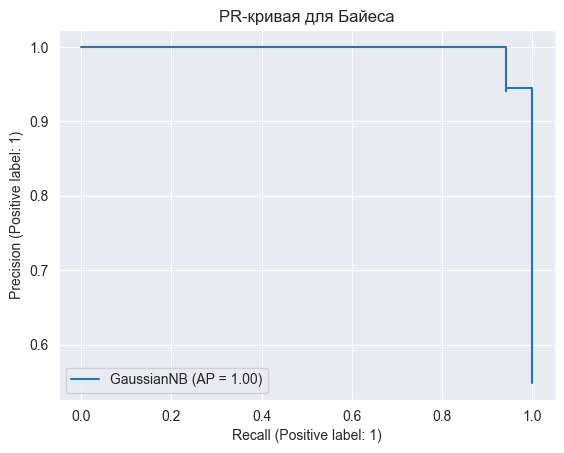

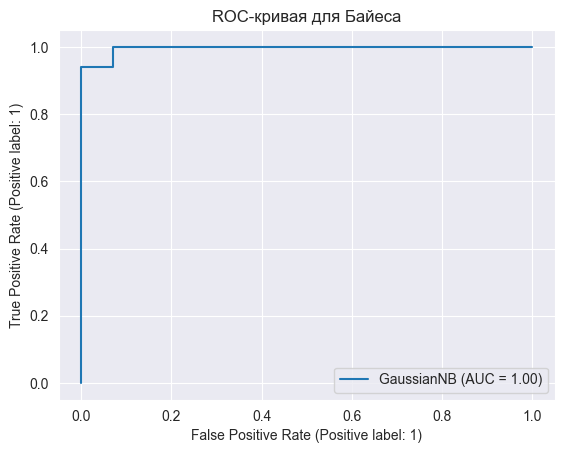

In [51]:
print_all_metrics(bayes, X_test_scale, y_test, 'Байеса')

Матрица ошибок:
[[10  4]
 [ 4 13]]




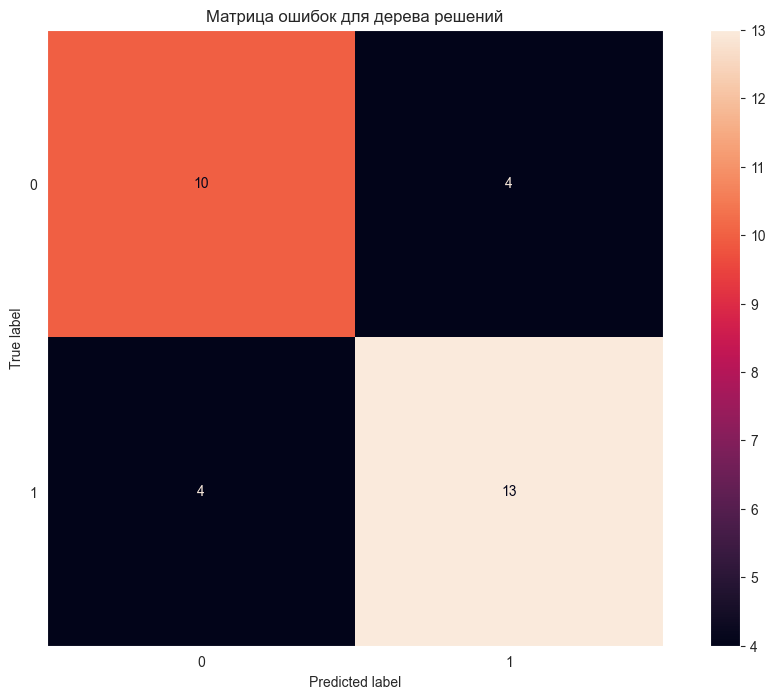

Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.76      0.76      0.76        17

    accuracy                           0.74        31
   macro avg       0.74      0.74      0.74        31
weighted avg       0.74      0.74      0.74        31




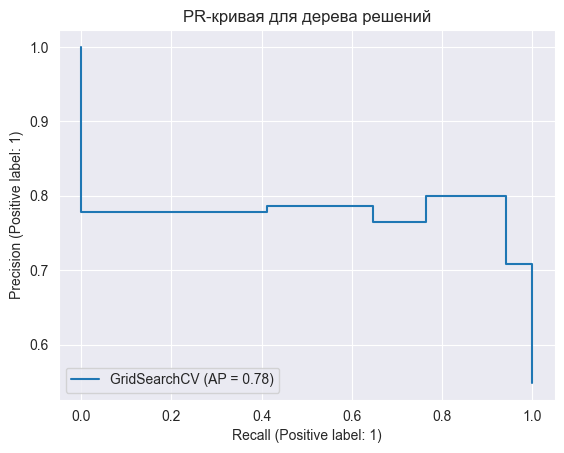

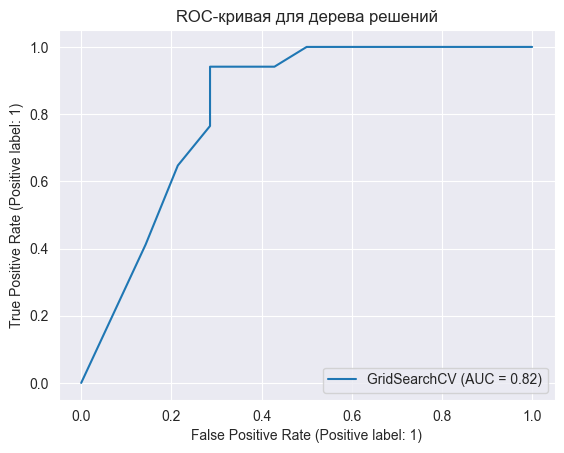

In [90]:
print_all_metrics(grid_tree_model, X_test_scale, y_test, 'дерева решений')

Матрица ошибок:
[[13  1]
 [ 1 16]]




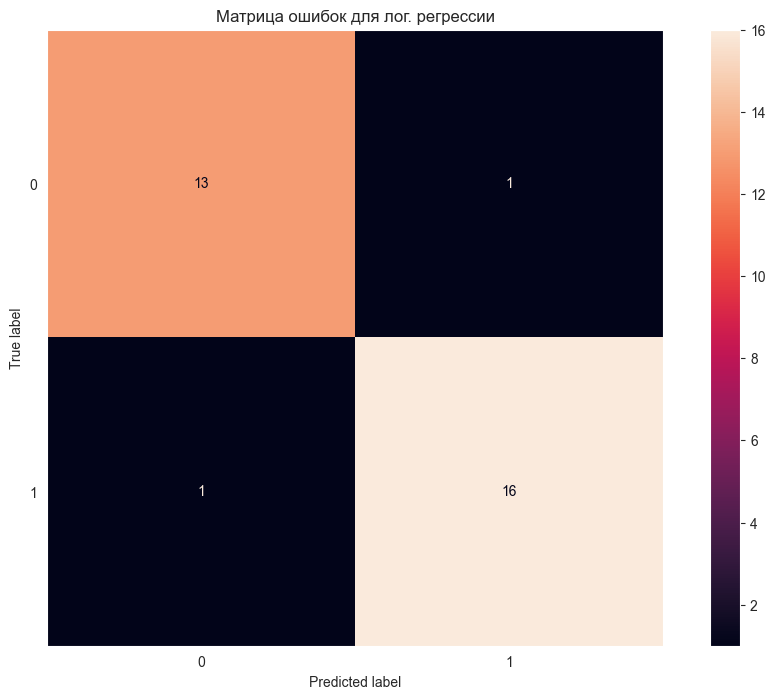

Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.94      0.94      0.94        17

    accuracy                           0.94        31
   macro avg       0.93      0.93      0.93        31
weighted avg       0.94      0.94      0.94        31




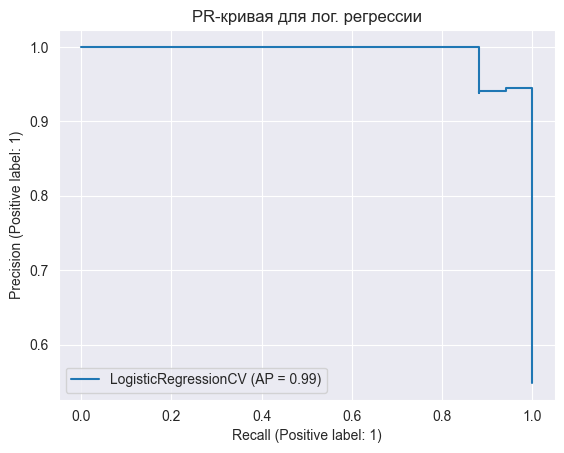

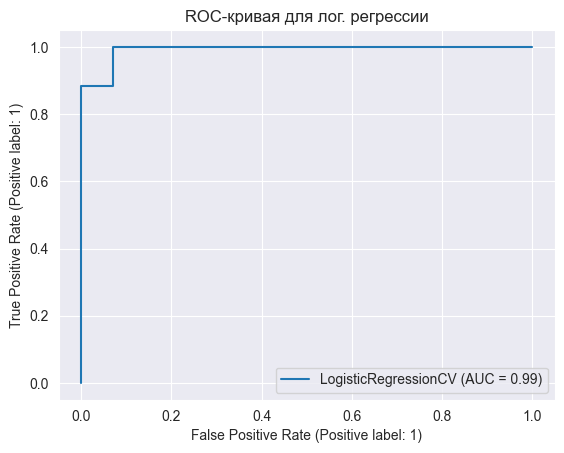

In [81]:
print_all_metrics(log_cv_model, X_test_scale, y_test, 'лог. регрессии')

Матрица ошибок:
[[11  3]
 [ 4 13]]




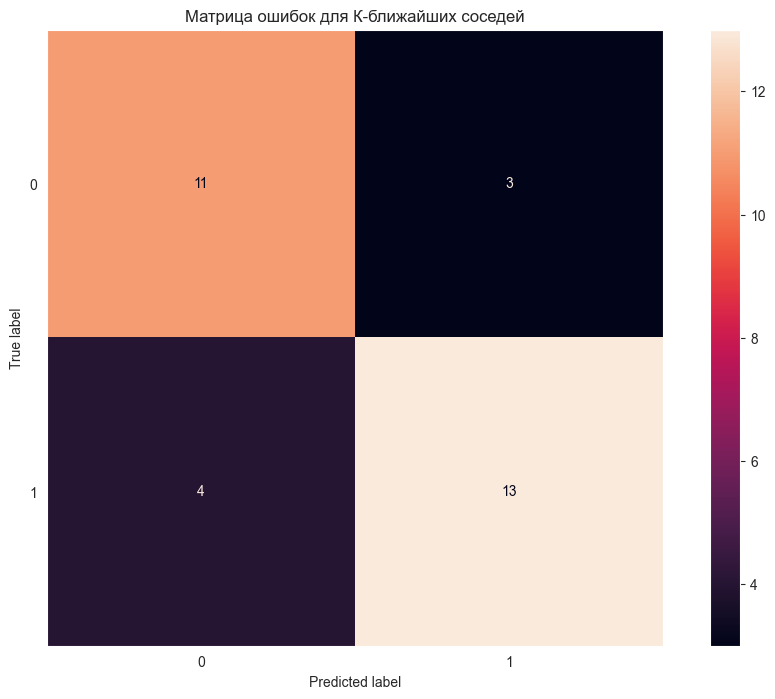

Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.81      0.76      0.79        17

    accuracy                           0.77        31
   macro avg       0.77      0.78      0.77        31
weighted avg       0.78      0.77      0.77        31




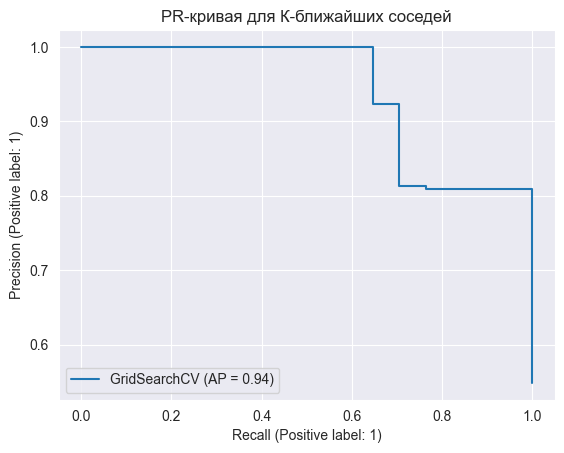

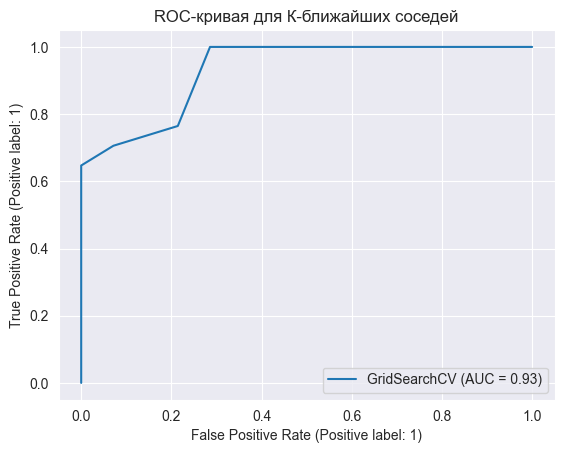

In [84]:
print_all_metrics(grid_knn_model, X_test_scale, y_test, 'К-ближайших соседей')

Матрица ошибок:
[[12  2]
 [ 2 15]]




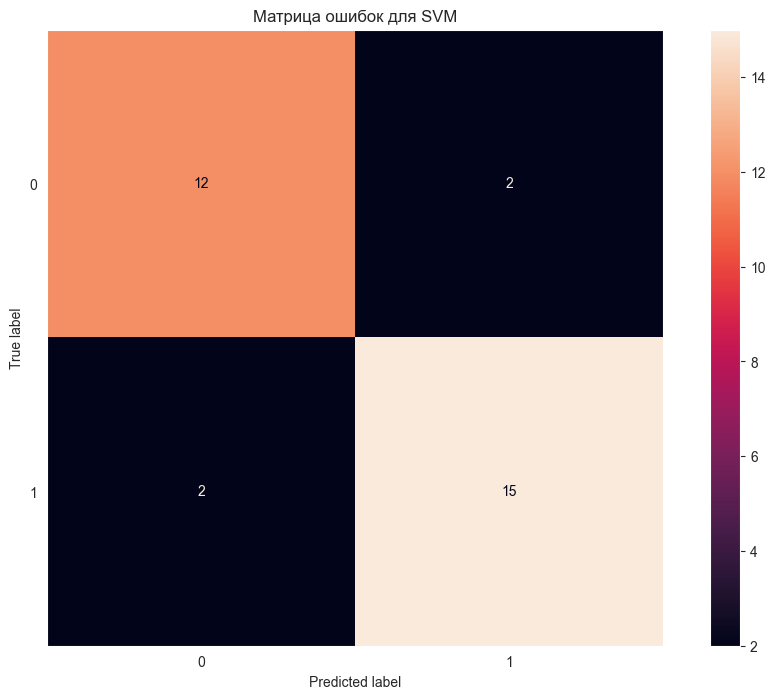

Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.88      0.88      0.88        17

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31




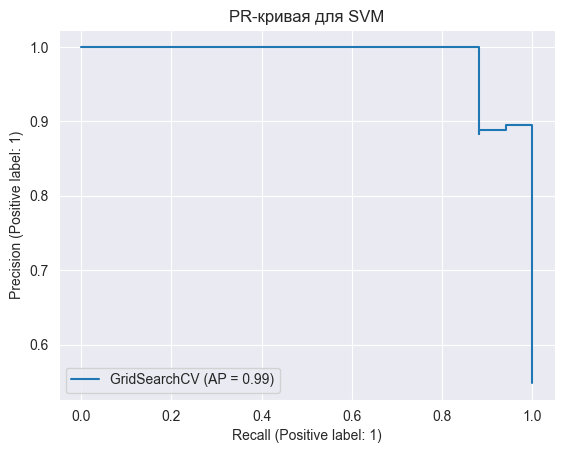

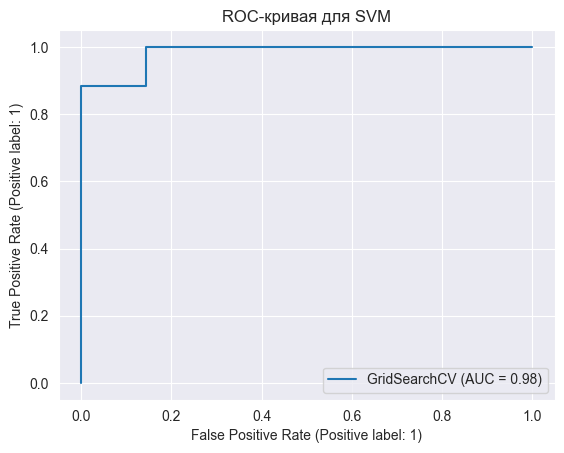

In [89]:
print_all_metrics(grid_svc, X_test_scale, y_test, 'SVM')

# Проверка моделей

**Представим, что в клинику пришёл пациент со следующими значениями признаков:**

    age          48.0
    sex           0.0
    cp            2.0
    trestbps    130.0
    chol        275.0
    fbs           0.0
    restecg       1.0
    thalach     139.0
    exang         0.0
    oldpeak       0.2
    slope         2.0
    ca            0.0
    thal          2.0

In [91]:
patient = [[54. , 1. , 0. , 122. , 286. , 0. , 0. , 116. , 1.,
          3.2, 1. , 2. ,2. ]]

**Предсказание класса LogisticRegressionCV**

In [96]:
pred_log = log_cv_model.predict(patient)
pred_log

array([0], dtype=int64)

**Предсказание класса Байесом**

In [97]:
pred_bayes = bayes.predict(patient)
pred_bayes

array([0], dtype=int64)

**Предсказание класса деревом решений**

In [98]:
pred_tree = grid_tree_model.predict(patient)
pred_tree

array([0], dtype=int64)

**Предсказание класса К-ближайшими соседями**

In [99]:
pred_knn = grid_knn_model.predict(patient)
pred_knn

array([1], dtype=int64)

**Предсказание класса SVM**

In [100]:
pred_svc = grid_svc.predict(patient)
pred_svc

array([0], dtype=int64)

# Итоговая таблица сравнения алгоритмов

In [102]:
bayes = [0.97, 0.97, 0.97, 0.97, 0]
decision_tree = [0.74, 0.74, 0.74, 0.74, 0]
log_regr = [0.93, 0.93, 0.93, 0.94, 0]
knn = [0.77, 0.78, 0.77, 0.77, 1]
svm = [0.87, 0.87, 0.87, 0.87, 0]
pd.DataFrame(data=[bayes, decision_tree, log_regr, knn, svm],
             columns=['Precision', 'Recall', 'F1-score', 'Accuracy', 'Итоговое предсказание'],
             index=['Байес', 'Дерево решений', 'Логистическая регрессия', 'К-ближайших соседей', 'Метод опорных векторов']
            )

,Precision,Recall,F1-score,Accuracy,Итоговое предсказание
Байес,0.97,0.97,0.97,0.97,0
Дерево решений,0.74,0.74,0.74,0.74,0
Логистическая регрессия,0.93,0.93,0.93,0.94,0
К-ближайших соседей,0.77,0.78,0.77,0.77,1
Метод опорных векторов,0.87,0.87,0.87,0.87,0


**Этот пациент должен иметь класс 0, то есть у него нет заболеваний сердца, так что основная масса моделей справилась с этой задачей. Цель проекта достигнута.**